In [1]:
cd Downloads

[WinError 2] The system cannot find the file specified: 'Downloads'
C:\Users\Rohan Krishna Ullas\Downloads


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import keras
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications import ResNet50


df1 = pd.read_csv("../input/fer2013/fer2013.csv")

print(df1.emotion.value_counts())
print(df1.head())

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


(48, 48)


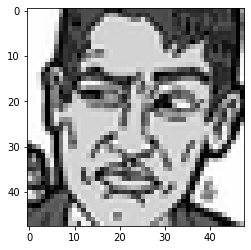

(48, 48)


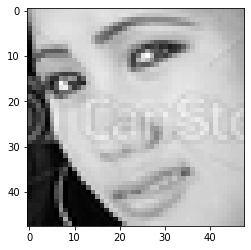

(48, 48)


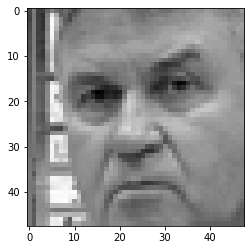

(48, 48)


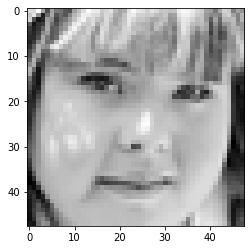

(48, 48)


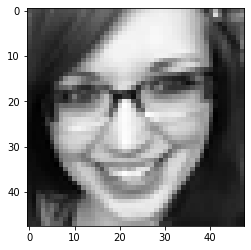

(48, 48)


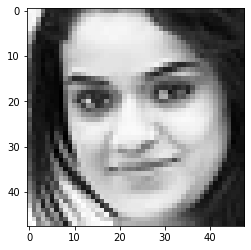

(48, 48)


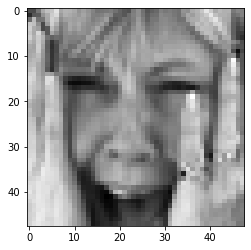

(48, 48)


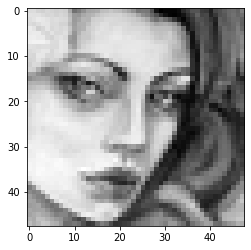

(48, 48)


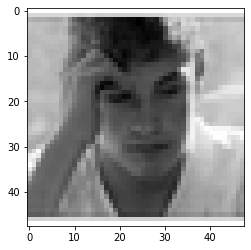

(48, 48)


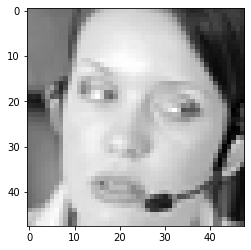

(28709, 48, 48, 1)


In [3]:
# Preprocessing
x_train=[]
x_test=[]
y_train=[]
y_test=[]
for i,row in df1.iterrows():
    k=row['pixels'].split(" ")
    if(row['Usage']=='Training'):
        x_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif(row['Usage']=='PublicTest'):
        x_test.append(np.array(k))
        y_test.append(row['emotion'])

x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

x_train=x_train.reshape(x_train.shape[0],48,48)
x_test=x_test.reshape(x_test.shape[0],48,48)
y_train=tf.keras.utils.to_categorical(y_train,num_classes=7)
y_test=tf.keras.utils.to_categorical(y_test,num_classes=7)

import matplotlib.pyplot as plt
for i in range(10):
  image=x_test[i].reshape((48,48))
  image=image.astype('float32')
  print(image.shape)
  plt.imshow(image,cmap=plt.cm.gray)
  plt.show()

'''
#Changing grayscale image shape to rgb image shape
#Repeating the image array 3 times on a new dimension. Because you will have the same image over all 3 channels, the performance of the model should be the same as it was on RGB images
print(x_train.shape)  # (64, 224, 224)
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)
print(x_train.shape)  # (64, 224, 224, 3)
'''

#data augmentation
x_train=x_train.reshape((x_train.shape[0],48,48,1))
x_test=x_test.reshape((x_test.shape[0],48,48,1))
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=60,
                                   shear_range=0.5,
                                   zoom_range=0.5,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(x_train)
validation_datagen.fit(x_test)

print(x_train.shape)


In [4]:
#detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model1=keras.models.Sequential()

    # Block-1
    model1.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                     kernel_initializer='he_normal',
                     activation="elu", 
                     input_shape=(48,48,1)))
    model1.add(keras.layers.BatchNormalization())

    model1.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                     kernel_initializer='he_normal', 
                     activation="elu"))

    model1.add(keras.layers.BatchNormalization())
    model1.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model1.add(keras.layers.Dropout(0.2))

    # Block-2
    model1.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                     kernel_initializer='he_normal',
                     activation="elu"))

    model1.add(keras.layers.BatchNormalization())

    model1.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',
                     kernel_initializer='he_normal', 
                     activation="elu"))

    model1.add(keras.layers.BatchNormalization())
    model1.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model1.add(keras.layers.Dropout(0.2))

    # Block-3
    model1.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                     kernel_initializer='he_normal', 
                     activation="elu"))
    model1.add(keras.layers.BatchNormalization())
    model1.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                     kernel_initializer='he_normal',
                     activation="elu"))

    model1.add(keras.layers.BatchNormalization())
    model1.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model1.add(keras.layers.Dropout(0.2))

    # Block-4
    model1.add(keras.layers.Flatten())
    model1.add(keras.layers.Dense(64, activation="elu", kernel_initializer='he_normal'))
    model1.add(keras.layers.BatchNormalization())
    model1.add(keras.layers.Dropout(0.5))

    # Block-5
    model1.add(keras.layers.Dense(7, activation="softmax", kernel_initializer='he_normal'))



    model1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        1

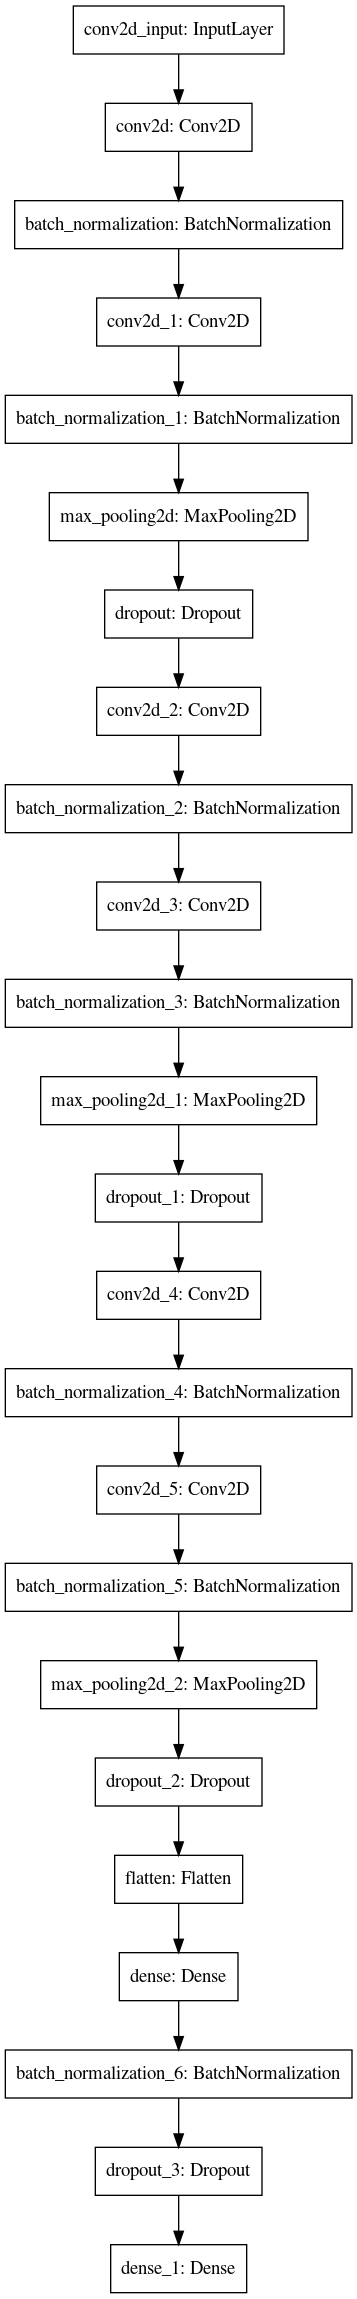

In [5]:
print(model1.summary())

#Model Plot
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

keras.utils.plot_model(model1, to_file='model.png', show_layer_names=True)


In [6]:
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

#intializing callbacks
early_stopping=keras.callbacks.EarlyStopping(patience=15,restore_best_weights=True)
filepath="weights/weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model1.fit(x_train,y_train,
           batch_size=64,
           epochs=50,
           validation_data=(x_test,y_test),
           verbose=1,callbacks=[early_stopping])                       
'''model1.fit_generator(train_datagen.flow(x_train,y_train,
                                  batch_size=64),
                                  epochs=150,
                                  validation_data=(x_test,y_test),
                                  verbose=1)'''

Epoch 1/50
449/449 [==============================] - 14s 31ms/step - loss: 1.9487 - accuracy: 0.3056 - val_loss: 1.4453 - val_accuracy: 0.4514
Epoch 2/50
449/449 [==============================] - 7s 15ms/step - loss: 1.4810 - accuracy: 0.4376 - val_loss: 1.3280 - val_accuracy: 0.4862
Epoch 3/50
449/449 [==============================] - 7s 16ms/step - loss: 1.3676 - accuracy: 0.4839 - val_loss: 1.2302 - val_accuracy: 0.5280
Epoch 4/50
449/449 [==============================] - 7s 16ms/step - loss: 1.3068 - accuracy: 0.5098 - val_loss: 1.2055 - val_accuracy: 0.5422
Epoch 5/50
449/449 [==============================] - 7s 16ms/step - loss: 1.2660 - accuracy: 0.5270 - val_loss: 1.1353 - val_accuracy: 0.5609
Epoch 6/50
449/449 [==============================] - 7s 15ms/step - loss: 1.2165 - accuracy: 0.5529 - val_loss: 1.2397 - val_accuracy: 0.5801
Epoch 7/50
449/449 [==============================] - 7s 16ms/step - loss: 1.1753 - accuracy: 0.5655 - val_loss: 1.0827 - val_accuracy: 0.592

'model1.fit_generator(train_datagen.flow(x_train,y_train,\n                                  batch_size=64),\n                                  epochs=150,\n                                  validation_data=(x_test,y_test),\n                                  verbose=1)'

In [7]:
print(model1.evaluate(x_test,y_test))

113/113 [==============================] - 1s 9ms/step - loss: 1.0367 - accuracy: 0.6186
[1.0367223024368286, 0.6185566782951355]


In [8]:
fer_json = model1.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
model1.save_weights("fer.h5")  

'\nfer_json = model1.to_json()  \nwith open("fer.json", "w") as json_file:  \n    json_file.write(fer_json)  \nmodel1.save_weights("fer.h5")  \n'

In [13]:
cd

/root


/kaggle/working/fer.json

In [10]:
from keras.models import model_from_json  
from keras.preprocessing import image  
  
'''
#load model  
model = model_from_json(open("fer.json", "r").read())  
#load weights  
model.load_weights('fer.h5')  
'''
  
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  
  
  
cap=cv2.VideoCapture(0)  
  
while True:  
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image  
    if not ret:  
        continue  
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)  
  
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)  
  
  
    for (x,y,w,h) in faces_detected:  
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)  
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image  
        roi_gray=cv2.resize(roi_gray,(48,48))  
        img_pixels = image.img_to_array(roi_gray)  
        img_pixels = np.expand_dims(img_pixels, axis = 0)  
        img_pixels /= 255  
  
        predictions = model.predict(img_pixels)  
  
        #find max indexed array  
        max_index = np.argmax(predictions[0])  
  
        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')  
        predicted_emotion = emotions[max_index]  
  
        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)  
  
    resized_img = cv2.resize(test_img, (1000, 700))  
    cv2.imshow('Facial emotion analysis ',resized_img)  
  
  
  
    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed  
        break  
  
cap.release()  
cv2.destroyAllWindows 

KeyboardInterrupt: 